In [1]:
import os
import pickle
import re

import matplotlib
from matplotlib import pyplot
import numpy
import pandas
import scipy
import seaborn
import tensorflow.keras
# from sklearn import preprocessing

import tensorflow.keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D

import logomaker

# Helper functions

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['legend.fontsize'] = 'small'
pandas.options.display.max_columns = None
pandas.options.display.max_colwidth = None

In [3]:
# Helper functions
def one_hot_encode(sequences, max_seq_len=None, mask_val=-1, padding='left'):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],
             'c':[0,1,0,0],
             'g':[0,0,1,0],
             't':[0,0,0,1],
             'n':[0,0,0,0]}

    # Automatically use max length if not specified
    if max_seq_len is None:
        max_seq_len = numpy.max([len(s) for s in sequences])
    
    # Creat empty matrix
    one_hot_seqs = numpy.ones([len(sequences), max_seq_len, 4])*mask_val
    
    # Iterate through sequences and one-hot encode
    for i, seq in enumerate(sequences):
        # Truncate
        if padding=='left':
            seq = seq[:max_seq_len]
        elif padding=='right':
            seq = seq[-max_seq_len:]
        else:
            raise ValueError(f'padding {padding} not recognized')
        # Convert to array
        seq = seq.lower()
        one_hot_seq = numpy.array([nuc_d[x] for x in seq])
        # Append to matrix
        if padding=='left':
            one_hot_seqs[i, :len(seq), :] = one_hot_seq
        elif padding=='right':
            one_hot_seqs[i, -len(seq):, :] = one_hot_seq
        else:
            raise ValueError(f'padding {padding} not recognized')
            
    return one_hot_seqs

# Load data

In [4]:
datasets = [
    {
        'cell_line': 'HEK293T',
        'replicate': 1,
        'path': '../polysome_profiling_sample2019/GSM3130435_egfp_unmod_1.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total_reads'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'Observed MRL', 'total_reads': 'Reads'},
    },
    {
        'cell_line': 'HEK293T',
        'replicate': 2,
        'path': '../polysome_profiling_sample2019/GSM3130436_egfp_unmod_2.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'Observed MRL', 'total': 'Reads'},
    },
    {
        'cell_line': 'T cells',
        'replicate': 1,
        'path': '../polysome_profiling_data/GSE232927_processed_defined_end_tcell_r1.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'Observed MRL', 'total': 'Reads'},
    },
    {
        'cell_line': 'T cells',
        'replicate': 2,
        'path': '../polysome_profiling_data/GSE232927_processed_defined_end_tcell_r2.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'Observed MRL', 'total': 'Reads'},
    },
    {
        'cell_line': 'HepG2',
        'replicate': 1,
        'path': '../polysome_profiling_data/GSE232927_processed_defined_end_hepg2_r1.csv.gz',
        'cols_to_load': ['UTR', 'rl', 'total'],
        'cols_to_rename': {'rl': 'Observed MRL', 'total': 'Reads'},
    }
]

In [5]:
# Load, preprocess, and compile data
multicol = pandas.MultiIndex(
    levels=[[], [], []],
    codes=[[], [], []],
    names=['Measurement', 'Cell type', 'Replicate'],
)
data_table_combined = pandas.DataFrame(columns=multicol)

for dataset in datasets:
    # Load only desired columns, rename
    data_table = pandas.read_csv(dataset['path'], usecols=dataset['cols_to_load'])
    data_table.rename(columns=dataset['cols_to_rename'], inplace=True)
    data_table['UTR'] = data_table['UTR'].str[:50]
    data_table = data_table.set_index('UTR')
    # Eliminate the large number of sequences with one read
    data_table = data_table[data_table['Reads'] > 1]

    # Convert to multiindex
    data_table = data_table[['Reads', 'Observed MRL']]
    multicol = pandas.MultiIndex.from_product(
        [['Reads', 'Observed MRL'], [dataset['cell_line']], [dataset['replicate']]],
        names=['Measurement', 'Cell type', 'Replicate'],
    )
    data_table.columns = multicol

    # Store
    data_table_combined = data_table_combined.merge(data_table, how='outer', left_index=True, right_index=True)
    
    print("{:,} sequences loaded for cell line {} rep {}.".format(len(data_table), dataset['cell_line'], dataset['replicate']))

# Set NaN reads to zero
data_table_combined['Reads'] = data_table_combined['Reads'].fillna(0)

# Add uATG
data_table_combined['uATG'] = False
data_table_combined.loc[data_table_combined.index.str.contains('ATG'), 'uATG'] = True
# data_table_combined.loc[~data_table_combined.index.str.contains('ATG'), 'uATG'] = False

display(data_table_combined)

326,033 sequences loaded for cell line HEK293T rep 1.
351,575 sequences loaded for cell line HEK293T rep 2.
349,633 sequences loaded for cell line T cells rep 1.
352,724 sequences loaded for cell line T cells rep 2.
789,594 sequences loaded for cell line HepG2 rep 1.


Measurement,Reads,Observed MRL,Reads,Observed MRL,Reads,Observed MRL,Reads,Observed MRL,Reads,Observed MRL,uATG
Cell type,HEK293T,HEK293T,HEK293T,HEK293T,T cells,T cells,T cells,T cells,HepG2,HepG2,
Replicate,1,1,2,2,1,1,2,2,1,1,
UTR,,,,,,,,,,,
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,4.0,6.436631,False
AAAAAAAAAAACAAGAACCCAGGTGGGTCTAGAGAAGGGATAGAAGCTCC,17.0,7.925491,28.0,7.464286,0.0,NaN,0.0,NaN,0.0,NaN,False
AAAAAAAAAAACTAAACAAAGACTAAGCTGCGGTCAGATATGTTAAACAA,11.0,10.011610,16.0,6.125000,0.0,NaN,0.0,NaN,0.0,NaN,True
AAAAAAAAAACTATACTAGGAAAGACATATTGCTAGGGATGCTCTGGGAT,0.0,NaN,0.0,NaN,5.0,0.000000,0.0,NaN,0.0,NaN,True
AAAAAAAAAACTATACTAGGAAAGACATCATGCTAGGGATGCTCTGGGAT,0.0,NaN,2.0,11.000000,0.0,NaN,0.0,NaN,0.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTTTGAGTTAGAAAACATTGGATCGGTCCGGGTCAAAGGGGAGATC,481.0,8.692710,159.0,7.050314,56.0,6.170554,111.0,7.805348,292.0,4.882561,False


In [6]:
# Separate into training, testing
# Same testing dataset for all models
# Use the 20,000 sequences with the highest *minimum* read across datasets

# Add min reads column
data_table_combined[('Reads', 'min', '')] = data_table_combined.loc[:, ('Reads', slice(None), slice(None))].min(axis=1)
# Sort
data_table_combined = data_table_combined.sort_values(('Reads', 'min', ''), ascending=False)
# Separate
data_test = data_table_combined.iloc[:20000]
data_trainval = data_table_combined.iloc[20000:]

In [7]:
# Function to train a CNN model
def train_model(data_train_x, data_train_y, data_val_x, data_val_y):

    # Define model
    # Model parameters
    input_len=50
    conv_padding='same'
    conv_kernel_size=8
    conv_filters=120
    conv_dropout_1=0.
    conv_dropout_2=0.
    conv_dropout_3=0.
    dense_units=40
    dense_dropout=0.2

    model = Sequential()
    model.add(
        Conv1D(
            activation="relu",
            input_shape=(input_len, 4),
            padding=conv_padding,
            filters=conv_filters,
            kernel_size=conv_kernel_size,
            name='conv_1',
        )
    )
    model.add(Dropout(conv_dropout_1))

    model.add(
        Conv1D(
            activation="relu",
            input_shape=(input_len, 1),
            padding=conv_padding,
            filters=conv_filters,
            kernel_size=conv_kernel_size,
            name='conv_2',
        )
    )
    model.add(Dropout(conv_dropout_2))

    model.add(
        Conv1D(
            activation="relu",
            input_shape=(input_len, 1),
            padding=conv_padding,
            filters=conv_filters,
            kernel_size=conv_kernel_size,
            name='conv_3',
        )
    )
    model.add(Dropout(conv_dropout_3))
        
    model.add(Flatten())

    model.add(Dense(dense_units, name='dense_1'))
    model.add(Activation('relu'))
    model.add(Dropout(dense_dropout))

    model.add(Dense(1, name='dense_2'))
    model.add(Activation('linear'))

    # Compile the model and train
    epochs = 50
    batch_size = 128
    learning_rate = 0.001

    # Callback: stop training after no improvement in validation
    callbacks = [
        tensorflow.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
        ),
    ]

    adam = tensorflow.keras.optimizers.Adam(learning_rate)
    model.compile(loss='mean_squared_error', optimizer=adam)

    training_history = model.fit(
        data_train_x,
        data_train_y,
        validation_data=(data_val_x, data_val_y),
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        callbacks=callbacks,
        verbose=1,
    )

    return model, training_history

In [8]:
for dataset_idx, dataset in enumerate(datasets):

    # Extract data from current dataset
    cell_line = dataset['cell_line']
    replicate = dataset['replicate']
    print(f"For cell line {cell_line}, replicate {replicate}:")

    data_trainval = data_table_combined.loc[
        :,
        (
            slice(None),
            cell_line,
            replicate,   
        )
    ]
    data_trainval = data_trainval.droplevel(level=[1, 2], axis=1)

    # Filter by number of reads
    print(f"Total number of sequences: {len(data_trainval):,}")
    data_trainval = data_trainval[data_trainval['Reads'] > 200]
    print(f"After filtering by read depth: {len(data_trainval):,}")

    # Separate training and validation sets
    data_trainval = data_trainval.sort_values('Reads', ascending=False)
    data_val = data_trainval.iloc[:10000].sample(frac=1)
    data_train = data_trainval.iloc[10000:].sample(frac=1)
    print(f"Sequences for training: {len(data_train):,}")
    print(f"Sequences for validation: {len(data_val):,}")

    # Extract model inputs and outputs
    data_train_x = one_hot_encode(data_train.index)
    data_train_y = data_train['Observed MRL'].values
    data_val_x = one_hot_encode(data_val.index)
    data_val_y = data_val['Observed MRL'].values

    # Train
    print("Training...")
    model, training_history = train_model(data_train_x, data_train_y, data_val_x, data_val_y)

    # Evaluate on testing dataset
    print("Predicting on test set...")
    data_test.loc[:, ('Predicted MRL', cell_line, replicate)] = model.predict(
        one_hot_encode(data_test.index)
    )

    print()

    del(model)
    tensorflow.keras.backend.clear_session()


For cell line HEK293T, replicate 1:
Total number of sequences: 878,252
After filtering by read depth: 291,889
Sequences for training: 281,889
Sequences for validation: 10,000
Training...
Epoch 1/50
2203/2203 [==============================] - 14s 5ms/step - loss: 1.6224 - val_loss: 0.6351
Epoch 2/50
2203/2203 [==============================] - 11s 5ms/step - loss: 1.0130 - val_loss: 0.4647
Epoch 3/50
2203/2203 [==============================] - 13s 6ms/step - loss: 0.8311 - val_loss: 0.3724
Epoch 4/50
2203/2203 [==============================] - 13s 6ms/step - loss: 0.6779 - val_loss: 0.3392
Epoch 5/50
2203/2203 [==============================] - 13s 6ms/step - loss: 0.5549 - val_loss: 0.3225
Epoch 6/50
2203/2203 [==============================] - 14s 6ms/step - loss: 0.4990 - val_loss: 0.2819
Epoch 7/50
2203/2203 [==============================] - 13s 6ms/step - loss: 0.4551 - val_loss: 0.2941
Epoch 8/50
2203/2203 [==============================] - 13s 6ms/step - loss: 0.4254 - val_lo

C:\Users\casti\AppData\Local\Temp\ipykernel_34612\180881545.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.loc[:, ('Predicted MRL', cell_line, replicate)] = model.predict(



For cell line HEK293T, replicate 2:
Total number of sequences: 878,252
After filtering by read depth: 163,788
Sequences for training: 153,788
Sequences for validation: 10,000
Training...
Epoch 1/50
1202/1202 [==============================] - 6s 5ms/step - loss: 1.2844 - val_loss: 0.5407
Epoch 2/50
1202/1202 [==============================] - 6s 5ms/step - loss: 0.8192 - val_loss: 0.3976
Epoch 3/50
1202/1202 [==============================] - 6s 5ms/step - loss: 0.7025 - val_loss: 0.3602
Epoch 4/50
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6219 - val_loss: 0.3549
Epoch 5/50
1202/1202 [==============================] - 7s 6ms/step - loss: 0.5505 - val_loss: 0.3077
Epoch 6/50
1202/1202 [==============================] - 7s 6ms/step - loss: 0.4883 - val_loss: 0.3020
Epoch 7/50
1202/1202 [==============================] - 7s 6ms/step - loss: 0.4291 - val_loss: 0.3131
Epoch 8/50
1202/1202 [==============================] - 7s 6ms/step - loss: 0.3859 - val_loss: 0.3

C:\Users\casti\AppData\Local\Temp\ipykernel_34612\180881545.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.loc[:, ('Predicted MRL', cell_line, replicate)] = model.predict(



For cell line T cells, replicate 1:
Total number of sequences: 878,252
After filtering by read depth: 174,257
Sequences for training: 164,257
Sequences for validation: 10,000
Training...
Epoch 1/50
1284/1284 [==============================] - 6s 5ms/step - loss: 1.3567 - val_loss: 0.4971
Epoch 2/50
1284/1284 [==============================] - 6s 5ms/step - loss: 0.9236 - val_loss: 0.5133
Epoch 3/50
1284/1284 [==============================] - 8s 6ms/step - loss: 0.8327 - val_loss: 0.4508
Epoch 4/50
1284/1284 [==============================] - 10s 7ms/step - loss: 0.7602 - val_loss: 0.4267
Epoch 5/50
1284/1284 [==============================] - 8s 6ms/step - loss: 0.7107 - val_loss: 0.4218
Epoch 6/50
1284/1284 [==============================] - 8s 6ms/step - loss: 0.6558 - val_loss: 0.4188
Epoch 7/50
1284/1284 [==============================] - 8s 6ms/step - loss: 0.6114 - val_loss: 0.4034
Epoch 8/50
1284/1284 [==============================] - 8s 6ms/step - loss: 0.5734 - val_loss: 0.

C:\Users\casti\AppData\Local\Temp\ipykernel_34612\180881545.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.loc[:, ('Predicted MRL', cell_line, replicate)] = model.predict(



For cell line T cells, replicate 2:
Total number of sequences: 878,252
After filtering by read depth: 216,141
Sequences for training: 206,141
Sequences for validation: 10,000
Training...
Epoch 1/50
1611/1611 [==============================] - 10s 6ms/step - loss: 1.9362 - val_loss: 0.6181
Epoch 2/50
1611/1611 [==============================] - 12s 7ms/step - loss: 1.2527 - val_loss: 0.5298
Epoch 3/50
1611/1611 [==============================] - 10s 6ms/step - loss: 1.1176 - val_loss: 0.4871
Epoch 4/50
1611/1611 [==============================] - 9s 6ms/step - loss: 1.0197 - val_loss: 0.4492
Epoch 5/50
1611/1611 [==============================] - 10s 6ms/step - loss: 0.9322 - val_loss: 0.4726
Epoch 6/50
1611/1611 [==============================] - 10s 6ms/step - loss: 0.8598 - val_loss: 0.4384
Epoch 7/50
1611/1611 [==============================] - 10s 6ms/step - loss: 0.8071 - val_loss: 0.4509
Epoch 8/50
1611/1611 [==============================] - 11s 7ms/step - loss: 0.7578 - val_lo

C:\Users\casti\AppData\Local\Temp\ipykernel_34612\180881545.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.loc[:, ('Predicted MRL', cell_line, replicate)] = model.predict(



For cell line HepG2, replicate 1:
Total number of sequences: 878,252
After filtering by read depth: 198,097
Sequences for training: 188,097
Sequences for validation: 10,000
Training...
Epoch 1/50
1470/1470 [==============================] - 9s 6ms/step - loss: 0.9995 - val_loss: 0.3569
Epoch 2/50
1470/1470 [==============================] - 9s 6ms/step - loss: 0.6733 - val_loss: 0.2638
Epoch 3/50
1470/1470 [==============================] - 8s 6ms/step - loss: 0.6061 - val_loss: 0.2579
Epoch 4/50
1470/1470 [==============================] - 9s 6ms/step - loss: 0.5541 - val_loss: 0.2480
Epoch 5/50
1470/1470 [==============================] - 9s 6ms/step - loss: 0.5093 - val_loss: 0.2365
Epoch 6/50
1470/1470 [==============================] - 9s 6ms/step - loss: 0.4756 - val_loss: 0.2288
Epoch 7/50
1470/1470 [==============================] - 9s 6ms/step - loss: 0.4524 - val_loss: 0.2360
Epoch 8/50
1470/1470 [==============================] - 10s 7ms/step - loss: 0.4283 - val_loss: 0.23

C:\Users\casti\AppData\Local\Temp\ipykernel_34612\180881545.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.loc[:, ('Predicted MRL', cell_line, replicate)] = model.predict(


In [9]:
# Save evaluations on test dataset
data_test.to_csv('test_with_separate_optimus5p.csv')

# Plot results

In [10]:
# Load data
data_test = pandas.read_csv(
    'test_with_separate_optimus5p.csv',
    header=[0,1,2],
    index_col=0,
)
# Fix Unnamed and integer columns
for i, columns_old in enumerate(data_test.columns.levels):
    columns_new = numpy.where(columns_old.str.contains('Unnamed'), '', columns_old)
    if i==2:
        columns_new = [int(c) if c.isdigit() else c for c in columns_new]
    data_test.rename(columns=dict(zip(columns_old, columns_new)), level=i, inplace=True)
data_test

Measurement                                           Reads Observed MRL  \
Cell type                                           HEK293T      HEK293T   
Replicate                                                 1            1   
UTR                                                                        
CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA  12126.0     3.039939   
CTAATCGCCCATTTAGGCGCGGATCATCCTATTCAGCCAGTGGATAAGCG   8838.0     7.800806   
GCGCATCACCACGGCCTCAGAGCAGCCCGCCTAGTACTCTGCCGCTTGTC   6177.0     7.606182   
CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT  10368.0     3.895109   
CCCCGAGGCTTGTGAGGAGTAAAACCCAAGAGAGGTAAAGTGCCACACAA   5503.0     4.654325   
...                                                     ...          ...   
GGATATCTGGCTTCAGTTGACAGTCCATATGTTCGTGCGTCCAATAAGAC   2617.0     5.709769   
GGGCGGAACTGACACCCAGTGTAGCGGCTCTAGGCCCGTTTGTGTCAAAT   1477.0     7.575314   
AAGAGGTAGCGGACCCAAGCCACACGCGTAGTAGGCCGACAGGAAGCCTG   2039.0     7.523474   
GAACAAGAACCCAAAAATCCTACAATGTCGGTGACTAATACAAACATAGA   3543.0     4.320166   
GGTTCGGCATGCAAACCCCAGGATATACATGCGGGATGGCTAAAACAGCT   2364.0     7.296828   

Measurement                                          Reads Observed MRL  \
Cell type                                          HEK293T      HEK293T   
Replicate                                                2            2   
UTR                                                                       
CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA  2633.0     2.688568   
CTAATCGCCCATTTAGGCGCGGATCATCCTATTCAGCCAGTGGATAAGCG  2802.0     6.458601   
GCGCATCACCACGGCCTCAGAGCAGCCCGCCTAGTACTCTGCCGCTTGTC  2457.0     6.499796   
CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT  2138.0     3.855005   
CCCCGAGGCTTGTGAGGAGTAAAACCCAAGAGAGGTAAAGTGCCACACAA  1954.0     3.646878   
...                                                    ...          ...   
GGATATCTGGCTTCAGTTGACAGTCCATATGTTCGTGCGTCCAATAAGAC   743.0     4.948856   
GGGCGGAACTGACACCCAGTGTAGCGGCTCTAGGCCCGTTTGTGTCAAAT   546.0     6.293040   
AAGAGGTAGCGGACCCAAGCCACACGCGTAGTAGGCCGACAGGAAGCCTG   546.0     6.437729   
GAACAAGAACCCAAAAATCCTACAATGTCGGTGACTAATACAAACATAGA   546.0     4.439560   
GGTTCGGCATGCAAACCCCAGGATATACATGCGGGATGGCTAAAACAGCT   546.0     6.750916   

Measurement                                          Reads Observed MRL  \
Cell type                                          T cells      T cells   
Replicate                                                1            1   
UTR                                                                       
CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA  4900.0     1.995057   
CTAATCGCCCATTTAGGCGCGGATCATCCTATTCAGCCAGTGGATAAGCG  2846.0     6.121909   
GCGCATCACCACGGCCTCAGAGCAGCCCGCCTAGTACTCTGCCGCTTGTC  3057.0     5.536605   
CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT  2598.0     3.531917   
CCCCGAGGCTTGTGAGGAGTAAAACCCAAGAGAGGTAAAGTGCCACACAA  3610.0     3.057525   
...                                                    ...          ...   
GGATATCTGGCTTCAGTTGACAGTCCATATGTTCGTGCGTCCAATAAGAC   546.0     4.212809   
GGGCGGAACTGACACCCAGTGTAGCGGCTCTAGGCCCGTTTGTGTCAAAT   554.0     6.168660   
AAGAGGTAGCGGACCCAAGCCACACGCGTAGTAGGCCGACAGGAAGCCTG   895.0     5.858491   
GAACAAGAACCCAAAAATCCTACAATGTCGGTGACTAATACAAACATAGA   801.0     3.400724   
GGTTCGGCATGCAAACCCCAGGATATACATGCGGGATGGCTAAAACAGCT   839.0     5.836508   

Measurement                                          Reads Observed MRL  \
Cell type                                          T cells      T cells   
Replicate                                                2            2   
UTR                                                                       
CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA  3865.0     2.583809   
CTAATCGCCCATTTAGGCGCGGATCATCCTATTCAGCCAGTGGATAAGCG  2570.0     6.745352   
GCGCATCACCACGGCCTCAGAGCAGCCCGCCTAGTACTCTGCCGCTTGTC  2711.0     5.934799   
CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT  2395.0     3.925099   
CCCCGAG

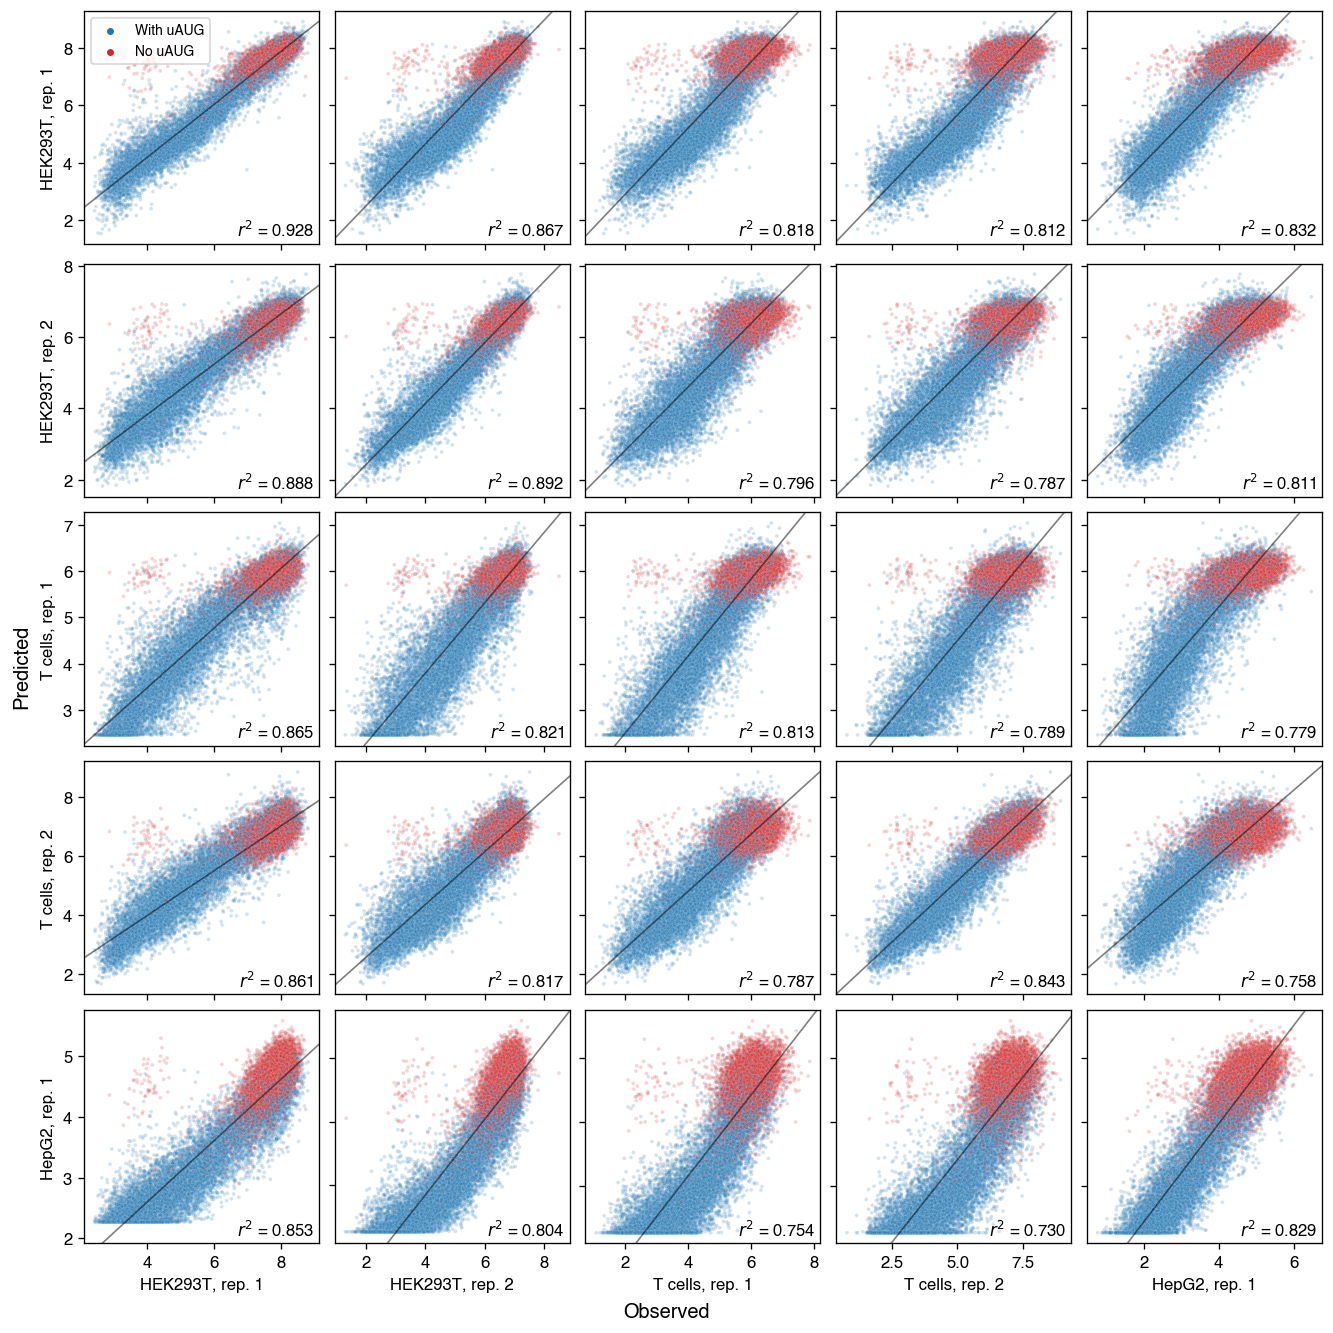

In [11]:
# Plot cell line vs. prediction
fig, axes = pyplot.subplots(
    len(datasets),
    len(datasets),
    figsize=(2.2*len(datasets), 2.2*len(datasets)),
    # sharex=True,
    # sharey=True,
    constrained_layout=True,
)

for dataset_obs_idx, dataset_obs in enumerate(datasets):
    for dataset_pred_idx, dataset_pred in enumerate(datasets):
        ax = axes[dataset_pred_idx, dataset_obs_idx]
        
        measurement_x = 'Observed MRL'
        cell_line_x = dataset_obs['cell_line']
        replicate_x = dataset_obs['replicate']
        measurement_y = 'Predicted MRL'
        cell_line_y = dataset_pred['cell_line']
        replicate_y = dataset_pred['replicate']
    
        # Extract data to plot from selected datasets
        data_to_plot = data_test.loc[
            :,
            [
                (measurement_x, cell_line_x, replicate_x),
                (measurement_y, cell_line_y, replicate_y),
            ]
        ]

        # Copy uAUG column
        data_to_plot['uATG'] = data_test['uATG'].astype(bool)

        # Assign whether uAUGs are present in the sequence
        data_to_plot.loc[data_to_plot['uATG'], 'uATG string'] = 'With uAUG'
        data_to_plot.loc[~data_to_plot['uATG'], 'uATG string'] = 'No uAUG'

        # Randomize order
        data_to_plot = data_to_plot.sample(frac=1)

        # Redefine columns for scatterplot
        xcol_name = f"{measurement_x}, {cell_line_x}, rep. {replicate_x}"
        ycol_name = f"{measurement_y}, {cell_line_y}, rep. {replicate_y}"
        data_to_plot = data_to_plot[
            [
                (measurement_x, cell_line_x, replicate_x),
                (measurement_y, cell_line_y, replicate_y),
                ("uATG string", '', ''),
            ]
        ]
        data_to_plot.columns = [xcol_name, ycol_name, "uATG string"]

        # Actually plot
        seaborn.scatterplot(
            data=data_to_plot,
            x=xcol_name,
            y=ycol_name,
            hue="uATG string",
            palette={'With uAUG': 'tab:blue', 'No uAUG': 'tab:red'},
            ax=ax,
            s=5,
            linewidth=0.2,
            alpha=0.2,
            edgecolor='white',
            rasterized=True,
            legend='auto' if (dataset_obs_idx==0 and dataset_pred_idx==0) else False,
        )

        # Regression line and r^2 text
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
            data_to_plot[xcol_name].values,
            data_to_plot[ycol_name].values,
        )
        ax.axline((3, 3*slope + intercept), slope=slope, color='k', linewidth=1, alpha=0.5)
        r2_text = f'$r^2$ = {r_value**2:.3f}'

        ax.text(
            ax.get_xlim()[1] - 0.02*(ax.get_xlim()[1] - ax.get_xlim()[0]),
            ax.get_ylim()[0] + 0.02*(ax.get_ylim()[1] - ax.get_ylim()[0]),
            r2_text,
            ha='right',
            va='bottom',
        )

        # Set axis labels based on position
        if dataset_pred_idx==len(datasets)-1:
            ax.set_xlabel(f"{cell_line_x}, rep. {replicate_x}")
        else:
            ax.xaxis.set_ticklabels([])
            ax.set_xlabel(None)
        if dataset_obs_idx==0:
            ax.set_ylabel(f"{cell_line_y}, rep. {replicate_y}")
        else:
            ax.yaxis.set_ticklabels([])
            ax.set_ylabel(None)
        fig.supxlabel('Observed')
        fig.supylabel('Predicted')

        # Legend
        if dataset_obs_idx==0 and dataset_pred_idx==0:
            seaborn.move_legend(ax, 'upper left')
            legend = ax.get_legend()
            legend.set_title(None)
            for lh in legend.legendHandles:
                lh.set_alpha(1)
                lh.set_sizes([10])

fig.savefig(f'mrl_vs_predictions_separate_scatter.svg', dpi=300, bbox_inches='tight')
fig.savefig(f'mrl_vs_predictions_separate_scatter.png', dpi=300, bbox_inches='tight')

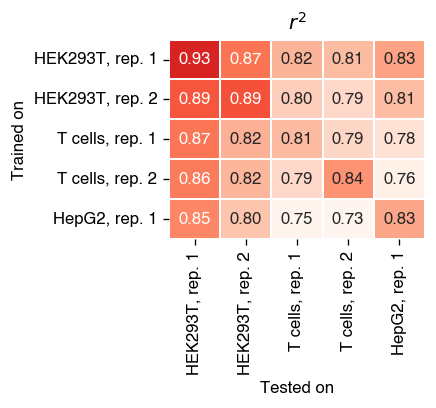

In [12]:
# Plot cell line vs. prediction
r2_matrix = numpy.zeros((len(datasets), len(datasets)))

for dataset_obs_idx, dataset_obs in enumerate(datasets):
    for dataset_pred_idx, dataset_pred in enumerate(datasets):
        
        measurement_obs = 'Observed MRL'
        cell_line_obs = dataset_obs['cell_line']
        replicate_obs = dataset_obs['replicate']
        measurement_pred = 'Predicted MRL'
        cell_line_pred = dataset_pred['cell_line']
        replicate_pred = dataset_pred['replicate']
    
        # Extract data to plot from selected datasets
        data_to_plot = data_test.loc[
            :,
            [
                (measurement_obs, cell_line_obs, replicate_obs),
                (measurement_pred, cell_line_pred, replicate_pred),
            ]
        ]

        # Regression line and r^2 text
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
            data_to_plot[(measurement_obs, cell_line_obs, replicate_obs)].values,
            data_to_plot[(measurement_pred, cell_line_pred, replicate_pred)].values,
        )
        
        r2_matrix[dataset_pred_idx, dataset_obs_idx] = r_value**2

# print(r2_matrix)

# Make dataframe with axis labels
xlabels = [
    f'{dataset["cell_line"]}, rep. {dataset["replicate"]}'
    for dataset in datasets
]
ylabels = [
    f'{dataset["cell_line"]}, rep. {dataset["replicate"]}'
    for dataset in datasets
]
r2_df = pandas.DataFrame(r2_matrix, index=ylabels, columns=xlabels)

# Plot heatmap
fig, ax = pyplot.subplots(figsize=(2.75, 2.2))
seaborn.heatmap(
    r2_df,
    annot=True,
    fmt='0.2f',
    vmin=0.75,
    vmax=1,
    ax=ax,
    cbar=False,
    # cbar_kws={'label': '$r^2$', 'aspect': 15},
    # edgecolors='k',
    linewidths=1,
    cmap='Reds',
)
ax.set_xlabel('Tested on')
ax.set_ylabel('Trained on')
ax.set_title('$r^2$')

fig.savefig(f'mrl_vs_predictions_separate_r2_heatmap.svg', dpi=300, bbox_inches='tight')
fig.savefig(f'mrl_vs_predictions_separate_r2_heatmap.png', dpi=300, bbox_inches='tight')